### 半监督学习

In [6]:
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split 
import numpy as np
import time

#### 加载数据

In [7]:
# 计时器
def timer (func):
    def wrapper(*args,**kwargs): 
        start = time.time()
        result = func(*args,**kwargs)
        end = time.time()
        print(func.__name__+'运行时间：',end-start)
        return result
    return wrapper

@timer
def load_train():
    # 导入数据
    y_train_df = pd.read_csv('../../preprocess_data/train_y_33465.csv',usecols=['label'])
    x_train_df = joblib.load('./x_train.lz4')
    x_train_df = x_train_df.fillna(-1)

    x_train_arr = x_train_df.values
    y_train_arr = y_train_df.values.ravel()
    return x_train_arr,y_train_arr

@timer
def load_unlabel():
    prob_unlabel_df = pd.read_csv('../predict_unlabel/preds/unlabel_pred.csv',usecols=['prob'])
    x_unlabel_df = joblib.load('./x_unlabel.lz4')
    unlabel_df = pd.concat([x_unlabel_df,prob_unlabel_df],axis=1)
    unlabel_df = unlabel_df.sort_values(by=['prob'],ascending=False)
    unlabel_df = unlabel_df.reset_index(drop=True)
    unlabel_df = unlabel_df.fillna(-1)


    y_unlabel_df = unlabel_df[['prob']].copy()
    x_unlabel_df = unlabel_df.drop(columns=['prob'])

    y_unlabel_df.loc[:int(0.1*len(y_unlabel_df)),'prob'] = 1
    y_unlabel_df.loc[int(0.1*len(y_unlabel_df)):,'prob'] = 0
    # 按prob 由高到低排列
    x_unlabel_arr = x_unlabel_df.values
    y_unlabel_arr = y_unlabel_df.values.ravel()


    # 颠倒一下正负样本的先后次序
    x_unlabel_0 = x_unlabel_arr[int(0.1*len(x_unlabel_df)):]
    x_unlabel_1 = x_unlabel_arr[:int(0.1*len(x_unlabel_df))]
    x_unlabel_arr = np.vstack((x_unlabel_0,x_unlabel_1))

    y_unlabel_0 = y_unlabel_arr[int(0.1*len(y_unlabel_df)):]
    y_unlabel_1 = y_unlabel_arr[:int(0.1*len(y_unlabel_df))]
    y_unlabel_arr = np.hstack((y_unlabel_0,y_unlabel_1))
    
    return x_unlabel_arr,y_unlabel_arr,-int(0.1*len(x_unlabel_df))

In [8]:
x_train_arr,y_train_arr = load_train()
x_unlabel_arr,y_unlabel_arr,start = load_unlabel()

load_train运行时间： 7.0759968757629395
load_unlabel运行时间： 27.868000984191895


In [9]:
START = start

#### 半监督相关函数

In [10]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier

# @timer
def gen_semiset(x_unlabel_arr,y_unlabel_arr,start=-6653,num=10,ratio=0.1):
    num_0 = num-int(num*ratio)
    num_1 = int(num*ratio)
    tmp = x_unlabel_arr[start-num_0:start+num_1]
    y_tmp = y_unlabel_arr[start-num_0:start+num_1]
    return tmp,y_tmp

# @timer
def combine_data(x_train_arr,y_train_arr,tmp,y_tmp):


    # 容易出错vstack hstack
    x_train_tmp = np.vstack((x_train_arr,tmp))
    y_train_tmp = np.hstack((y_train_arr,y_tmp))
    return x_train_tmp,y_train_tmp

# @timer
def gen_local_train(x_unlabel_arr,y_unlabel_arr,x_train_arr,y_train_arr,
                    start=-6653,num=10,ratio=0.1):
    tmp,y_tmp = gen_semiset(x_unlabel_arr,y_unlabel_arr,start,num,ratio)
    return combine_data(x_train_arr,y_train_arr,tmp,y_tmp)

# @timer
def stratify_split(x_train_arr,y_train_arr,random_state=3096,test_size=0.3):
    # 层次划分出local test 
    
    x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(x_train_arr,
                                                                        y_train_arr,
                                                                        random_state=random_state,
                                                                        test_size=test_size,
                                                                        stratify=y_train_arr)
    return  x_train_new, x_test_new, y_train_new, y_test_new


# @timer
def train(x_train,y_train,x_test,y_test,model_name='rfc'):
    #2.建立模型 
#     model_names = ['rfc','gbc','xgb','lgb','dtc']
    if model_name == 'rfc':
        # RandomForestClassifier
        
        rfc  =RandomForestClassifier(n_estimators=10,
                                     n_jobs =32,
                                     max_features='sqrt',
                                     class_weight='balanced',
#                                      verbose =1,
                                     random_state=2018)
    elif model_name == 'gbc':
        
        gbc = GradientBoostingClassifier(loss='deviance',learning_rate =0.1,n_estimators=300,subsample=0.9,max_depth=3,verbose=1,random_state=2018)
    elif model_name == 'xgb':
        
        params={
        'booster':'gbtree',
        'objective': 'binary:logistic',
        'early_stopping_rounds':100,
        'scale_pos_weight': float(len(data_label)-np.sum(data_label.values))/float(np.sum(data_label.values)),  # 负例样本除以正例样本
        'eval_metric': 'auc',
        'gamma':1,
        'max_depth':6,
        'lambda':1,
        'subsample':0.9,
        'colsample_bytree':0.9,
        'min_child_weight':1, 
        'eta': 0.04,
        'seed':2010,
        'nthread':32
            }
    elif model_name == 'lgb':
        
        parameters = {
            'boost':'gbdt',
            'num_leaves':135, 
            'scale_pos_weight':float(len(y_train)-np.sum(y_train.ravel()))/float(np.sum(y_train.ravel())),
            'max_depth':-1,
            'learning_rate':.05,
            'max_bin':200,
            'min_data_in_leaf' : 60,
            'objective':'binary',
            'metric':'auc',
            'verbose':1,
            'num_threads':36
        }
    elif model_name == 'dtc':
        dtc = DecisionTreeClassifier(class_weight='balanced')
    else:
        pass

    #3.训练模型
#     print('开始训练！')
    import joblib
    if model_name == 'rfc':
        rfc.fit(x_train,y_train)
    #     joblib.dump(rfc,'./model/rfc_model')
    elif model_name == 'gbc':
        gbc.fit(x_train,y_train)
    #     joblib.dump(gbc,'./model/rgbc_model')
    elif model_name =='xgb':
        dtrain = xgb.DMatrix(x_train,y_train)
        dvalid = xgb.DMatrix(x_test,y_test)
        dtest = xgb.DMatrix(x_test)
        watchlist  = [(dvalid,'valid')]
        xgb_model = xgb.train(params,dtrain,num_boost_round=300,evals=watchlist)
    #     xgb_model.save_model('./model/xgb_model')
    elif model_name == 'lgb':
        lgb_train = lgb.Dataset(x_train, y_train.ravel())
        lgb_model = lgb.train(parameters,lgb_train,num_boost_round=50)
    #     lgb_model.save_model('./model/lgb_model')
    elif model_name == 'dtc':
        dtc.fit(x_train,y_train)
    else:
        pass
    # lg.fit(x_train,y_train.ravel())
    # lsvm.fit(x_train,y_train)
    # history = model.fit(x_train,y_train,epochs=2,batch_size=1024,class_weight = 'auto',validation_data=(x_test,y_test))
     #4.预测结果
#     print('开始预测！')
    if model_name=='rfc':
        y_pre = rfc.predict_proba(x_test)[:,1]
    elif model_name=='gbc':
        y_pre = gbc.predict_proba(x_test)[:,1]
    elif model_name=='xgb':
        dtest = xgb.DMatrix(x_test)
        y_pre = xgb_model.predict(dtest).ravel()
    elif model_name=='lgb':
        y_pre = lgb_model.predict(x_test)
    elif model_name == 'dtc':
        y_pre = dtc.predict(x_test)[:,1]
    else:
        pass
    
    auc = metrics.roc_auc_score(y_test, y_pre)
#     print('AUC:',auc)
    return auc
        

In [11]:
x_train_new, x_test_new, y_train_new, y_test_new = stratify_split(x_train_arr,y_train_arr,random_state=2018,test_size=0.3)

In [12]:

def progress(percent,width=50):
    '''进度打印功能'''
    if percent >= 100:
        percent=100
  
    show_str='[%-*s]' %(width,int(width * percent/100)*">") #字符串拼接的嵌套使用
    print('\r%s %d%%' %(show_str,percent),end='') # \r 回到行首，覆盖之前的

@timer
def semi_train(iter=3,start=-6653,step=10,length=40,early_stop=120):
    print('第{}轮：'.format(iter))
    auc_list = []
    num_list = []
    early_tmp = 0
    for num in range(0,length,step):
        # ratio取值范围：1/16 ~1/10
        x_train_tmp,y_train_tmp = gen_local_train(x_unlabel_arr,y_unlabel_arr,x_train_new,y_train_new,start,num,1/step)
        auc = train(x_train_tmp,y_train_tmp,x_test_new,y_test_new,model_name='rfc')
        auc_list.append(auc)
        num_list.append(num)
        # early_stopping 模块
        if len(auc_list)<=1:
            pass
        
        if (len(auc_list)>=2) and (auc_list[-1]<auc_list[-2]):
            early_tmp += 1
        else:
            if early_tmp <=0 :
                pass
            else:
                early_tmp -= 1 
                
        if early_tmp >= early_stop:
            break
        progress(int(num/length*100))
        
        # 分阶段保存
        if num%int(length/20)==0:
            log = dict(random_seed=2018,auc_list=auc_list,num_list=num_list)
            joblib.dump(log,'./log{}'.format(iter))

    log = dict(random_seed=2018,auc_list=auc_list,num_list=num_list)
    joblib.dump(log,'./log{}'.format(iter))


In [ ]:
params = [(6,30000),(8,30000),(10,30000),(12,30000),(14,30000),(16,30000)]
for i in range(5,-1,-1):
    step=params[i][0]
    length=params[i][1]
    early_stop=int(500/step)
    semi_train(i,START,step,length,early_stop)

第5轮：
[>>>>>>                                            ] 13%

In [5]:
[i for i in range(5,-1,-1)]

[5, 4, 3, 2, 1, 0]

random_seed: 2018


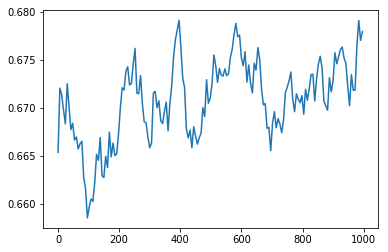

In [17]:
show('log0')

### 观察表现

In [16]:
import joblib 
import matplotlib.pyplot as plt
%matplotlib inline

def show(log_path):
    log= joblib.load(log_path)
    print('random_seed:',log['random_seed'])
    plt.plot(log['num_list'],pd.DataFrame(log['auc_list'],columns=['auc']).ewm(alpha=0.2).mean().values)

### 第二组（ratio=1/16,random_seed = 2018,step = 16）

In [36]:
# 保存
import joblib 
log2 = dict(random_seed=2018,auc_list=auc_list,num_list=num_list)
joblib.dump(log2,'./log2')


random_seed: 2018


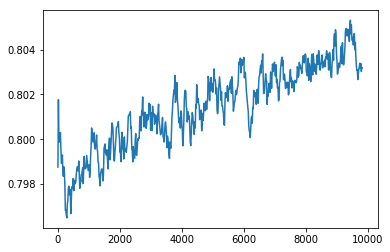

In [39]:
show('log2')

### 第一组记录 (ratio=1/10,random_seed = 3096,step = 10)

In [ ]:
# 保存
import joblib 
log1 = dict(random_seed=3096,auc_list=auc_list,num_list=num_list)
joblib.dump(log1,'./log1')

random_seed: 3096


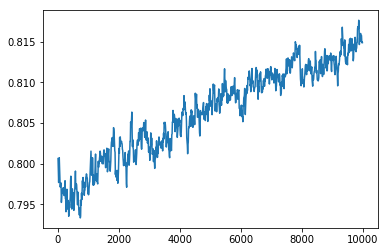

In [40]:
show('log1')

## 线上

### xgb bagging

In [36]:
test_id = pd.read_csv('../../preprocess_data_new/valid_date.csv',usecols=['id']).values.ravel()

In [37]:
import xgboost as xgb
dtrain = xgb.DMatrix(x, y, feature_names=list(data.columns))
dtest = xgb.DMatrix(x_test, feature_names=list(valid.columns))

In [38]:
def pipeline(dtrain,dtest,test_id,iteration,random_seed,gamma,max_depth,lambd,subsample,colsample_bytree,min_child_weight):
    if max_depth==6:
        num_boost_round = 210
    elif max_depth==7:
        num_boost_round = 180
    elif max_depth==8:
        num_boost_round = 150
    
    params={
    'booster':'gbtree',
    'objective': 'binary:logistic',
    'early_stopping_rounds':100,
    'scale_pos_weight': float(len(data_label)-np.sum(data_label.values))/float(np.sum(data_label.values)),  # 负例样本除以正例样本
    'eval_metric': 'auc',
    'gamma':gamma,
    'max_depth':max_depth,
    'lambda':lambd,
    'subsample':subsample,
    'colsample_bytree':colsample_bytree,
    'min_child_weight':min_child_weight, 
    'eta': 0.04,
    'seed':random_seed,
    'nthread':32
        }
    watchlist  = [(dtrain,'train')]
    model = xgb.train(params,dtrain,num_boost_round=num_boost_round,evals=watchlist)
    model.save_model('./xgb_models1/xgb{0}.model'.format(iteration))
    
    #predict test set
    test_y = model.predict(dtest)
    test_result = pd.DataFrame(test_id,columns=["id"])
    test_result['score'] = test_y
    test_result.to_csv("./xgb_preds1/xgb{0}.csv".format(iteration),index=None,encoding='utf-8')
    
    #get feature score
    feature_score = model.get_fscore()
    feature_score = sorted(feature_score.items(), key=lambda x:x[1],reverse=True)
    fs = []
    for (key,value) in feature_score:
        fs.append("{0},{1}\n".format(key,value))
    
    with open('./xgb_featurescores1/feature_score_{0}.csv'.format(iteration),'w') as f:
        f.writelines("feature,score\n")
        f.writelines(fs)

In [1]:
%%time
import sys,random

random_seed = list(range(1000,2000,20))
gamma = [i/1000.0 for i in range(100,200,2)]
max_depth = [6,7,8]
lambd = list(range(200,400,2))
subsample = [i/1000.0 for i in range(600,700,2)]
colsample_bytree = [i/1000.0 for i in range(250,350,2)]
min_child_weight = [i/1000.0 for i in range(200,300,2)]
random.shuffle(random_seed)
random.shuffle(gamma)
random.shuffle(max_depth)
random.shuffle(lambd)
random.shuffle(subsample)
random.shuffle(colsample_bytree)
random.shuffle(min_child_weight)

with open('params.pkl','wb') as f:
    joblib.dump((random_seed,gamma,max_depth,lambd,subsample,colsample_bytree,min_child_weight),f)

#to reproduce my result, uncomment following lines
"""
with open('params_for_reproducing.pkl','rb') as f:
    random_seed,gamma,max_depth,lambd,subsample,colsample_bytree,min_child_weight = pickle.load(f)    
"""

for i in range(36):
    pipeline(dtrain,dtest,test_id,i,random_seed[i],gamma[i],max_depth[i%3],lambd[i],subsample[i],colsample_bytree[i],min_child_weight[i])

In [34]:
def SelectModel(model_name):
    if model_name == 'GBC':
        from sklearn.ensemble import GradientBoostingClassifier
        model = GradientBoostingClassifier(loss='deviance',
                                           learning_rate =0.1,
                                           n_estimators=300,
                                           subsample=0.9,
                                           max_depth=3,
#                                            verbose=1,
                                          random_state=2018)
    elif model_name == 'XGB':
        from xgboost import XGBClassifier

        model = XGBClassifier(max_depth=6,
                              learning_rate =0.04, 
                              booster='gbtree',
                              objective='binary:logistic',
                              early_stopping_rounds=100,
                              scale_pos_weight=float(len(y_train)-np.sum(y_train))/float(np.sum(y_train)),
                              eval_metric='auc',
                              gamma=1,
                              reg_lambda=1,
                              subsample=0.9,
                              min_child_weight=1,
                              seed=2018,
                              silent=False,
                              n_jobs=36,
                              num_boost_round =300
                             )
    elif model_name == 'RFC':
        from sklearn.ensemble import RandomForestClassifier
        model = RandomForestClassifier(n_estimators=1500,
                                       n_jobs =36,
                                       max_features='sqrt',
                                       class_weight='balanced',
                                       verbose =1,
                                       random_state=2018)
    elif model_name == 'LGB':
        from lightgbm import LGBMClassifier
        model = LGBMClassifier(boost='gbdt',
                    num_leaves=135, 
                    scale_pos_weight=float(len(y_train)-np.sum(y_train.ravel()))/float(np.sum(y_train.ravel())),
                    max_depth=-1,
                    learning_rate=.04,
                    max_bin=200,
                    min_data_in_leaf= 60,
                    objective='binary',
                    metric='auc',
                    num_threads=32,
                    slient=False,
                    num_boost_round =400)
    else:
        pass
    return model

def get_oof(clf,n_folds,x_train,y_train,x_test):
    n_train = x_train.shape[0]
    n_test = x_test.shape[0]
    num_class = len(np.unique(y_train))
    kf = KFold(n_splits=n_folds,random_state=2018)
    oof_train = np.zeros((n_train,num_class-1))
    oof_test = np.zeros((n_test,num_class-1))
    
    for i,(train_index,test_index)in enumerate(kf.split(x_train,y_train)):
        print(i)
        kf_x_train = x_train[train_index]
        kf_y_train = y_train[train_index]
        kf_x_test = x_train[test_index]
        
        clf.fit(kf_x_train,kf_y_train)
        tmp_trafold = clf.predict_proba(kf_x_test)
        tmp_test = clf.predict_proba(x_test)
        if tmp_trafold.ndim != 1:
            tmp_trafold = tmp_trafold[:,1:]
            tmp_test = tmp_test[:,1:]
        oof_train[test_index] = tmp_trafold
        oof_test += tmp_test
        
    oof_test = oof_test/n_folds
    return oof_train,oof_test


In [ ]:
%%time
rfc_model = SelectModel('RFC')
rfc_model.fit(x_train,y_train)
joblib.dump(rfc_model,'rfc_model')

lgb_model = SelectModel('LGB')
lgb_model.fit(x_train,y_train)
joblib.dump(lgb_model,'lgb_model')

xgb_model = SelectModel('XGB')
xgb_model.fit(x_train,y_train)
joblib.dump(xgb_model,'xgb_model')

gbc_model = SelectModel('GBC')
gbc_model.fit(x_train,y_train)
joblib.dump(gbc_model,'gbc_model')



[Parallel(n_jobs=36)]: Using backend ThreadingBackend with 36 concurrent workers.
[Parallel(n_jobs=36)]: Done 128 tasks      | elapsed:    5.4s
[Parallel(n_jobs=36)]: Done 378 tasks      | elapsed:   14.2s
[Parallel(n_jobs=36)]: Done 728 tasks      | elapsed:   26.2s


### voting

In [26]:
test_id = pd.read_csv('../../preprocess_data_new/valid_date.csv',usecols=['id']).values.ravel()

In [1]:
import joblib
rfc_model = joblib.load('rfc_model')
lgb_model = joblib.load('lgb_model')
xgb_model = joblib.load('xgb_model')
gbc_model = joblib.load('gbc_model')

In [29]:
rfc_pred = rfc_model.predict_proba(x_test[:,:10800])[:,1]
lgb_pred = lgb_model.predict_proba(x_test)[:,1]
xgb_pred = xgb_model.predict_proba(x_test)[:,1]
gbc_pred = gbc_model.predict_proba(x_test)[:,1]

[Parallel(n_jobs=36)]: Using backend ThreadingBackend with 36 concurrent workers.
[Parallel(n_jobs=36)]: Done 128 tasks      | elapsed:    0.2s
[Parallel(n_jobs=36)]: Done 378 tasks      | elapsed:    0.3s
[Parallel(n_jobs=36)]: Done 728 tasks      | elapsed:    0.6s
[Parallel(n_jobs=36)]: Done 1178 tasks      | elapsed:    0.9s
[Parallel(n_jobs=36)]: Done 1500 out of 1500 | elapsed:    1.1s finished


In [35]:
pred = pd.DataFrame()
pred['id'] = test_id
pred['prob'] = (rfc_pred + lgb_pred + xgb_pred + gbc_pred)/4
import os
if not os.path.exists('./pred'):
    os.mkdir('pred')
pred.to_csv('./pred/voting_pred.txt',index=False)

xgb_pred.to_csv('./pred/voting_pred.txt',index=False)

In [36]:
rfc_res = pd.DataFrame()
rfc_res['id'] = test_id
rfc_res['prob'] = rfc_pred
rfc_res.to_csv('./pred/rfc_res.txt',index=False)

voting_pred AUC:0.8121
rfc_res AUC:0.78029396528571

In [13]:
feature_score = pd.Series(index=data.columns,data=rfc_model.feature_importances_)

In [29]:
feature_score.sort_values(ascending=False) 

sf5567    0.005345
df5773    0.003776
sf774     0.002786
sf5322    0.002509
sf3789    0.002225
df5800    0.002219
sf1930    0.002198
sf6263    0.002123
sf3890    0.002120
sf2552    0.002108
sf1554    0.002059
sf6072    0.002029
sf659     0.002025
sf2668    0.002014
sf6518    0.002003
sf1228    0.001995
sf2521    0.001975
sf2145    0.001973
sf3810    0.001955
sf3267    0.001899
sf46      0.001828
sf3453    0.001703
df1469    0.001689
sf1561    0.001653
sf4880    0.001606
sf4968    0.001561
sf3884    0.001554
sf6437    0.001533
sf3688    0.001502
sf1276    0.001459
            ...   
df5223    0.000000
df6256    0.000000
df1785    0.000000
df4222    0.000000
df4223    0.000000
mf2792    0.000000
mf1582    0.000000
mf2186    0.000000
df1738    0.000000
mf6468    0.000000
mf6247    0.000000
df1849    0.000000
df6216    0.000000
df1864    0.000000
mf6052    0.000000
df1992    0.000000
df5197    0.000000
mf6089    0.000000
mf1646    0.000000
mf2874    0.000000
df1937    0.000000
mf6138    0.

### 神经网络效果很差

In [45]:
from keras import models 
from keras import layers 
def build_model(): 
    model = models.Sequential() 
    model.add(layers.Dense(50,activation='relu',input_shape=(11334,))) 
    model.add(layers.Dense(20,activation='relu')) 
    model.add(layers.Dense(1,activation='sigmoid'))
    
    model.compile(optimizer='rmsprop',# 还可以通过optimizer = optimizers.RMSprop(lr=0.001)来为优化器指定参数 
                  loss='binary_crossentropy', # 等价于loss = losses.binary_crossentropy 
                  metrics=['accuracy'] # 等价于metrics = [metircs.binary_accuracy]
                  )  
    return model 
model = build_model()
history = model.fit(x_train,y_train,epochs=10,batch_size=1024,class_weight = 'auto',validation_data=(x_test,y_test))

Train on 23425 samples, validate on 10040 samples
Epoch 1/10
23425/23425 [==============================] - 2s 106us/step - loss: 14.7869 - acc: 0.0725 - val_loss: 14.7183 - val_acc: 0.0768
Epoch 2/10
23425/23425 [==============================] - 2s 100us/step - loss: 14.7869 - acc: 0.0725 - val_loss: 14.7183 - val_acc: 0.0768
Epoch 3/10
23425/23425 [==============================] - 2s 106us/step - loss: 14.7869 - acc: 0.0725 - val_loss: 14.7183 - val_acc: 0.0768
Epoch 4/10
23425/23425 [==============================] - 2s 89us/step - loss: 14.7869 - acc: 0.0725 - val_loss: 14.7183 - val_acc: 0.0768
Epoch 5/10
23425/23425 [==============================] - 3s 117us/step - loss: 14.7869 - acc: 0.0725 - val_loss: 14.7183 - val_acc: 0.0768
Epoch 6/10
23425/23425 [==============================] - 2s 89us/step - loss: 14.7869 - acc: 0.0725 - val_loss: 14.7183 - val_acc: 0.0768
Epoch 7/10
23425/23425 [==============================] - 2s 92us/step - loss: 14.7869 - acc: 0.0725 - val_loss:

In [47]:
y_pred = model.predict_proba(x_test)

In [48]:
# 评价指标 AUC
from sklearn import metrics
metrics.roc_auc_score(y_test,y_pred)

0.49732174296011206

In [217]:
%%time
# 第一级
model_list = ['XGB','RFC','LGB']
new_train_list = []
new_test_list = []
for model in model_list:
    clf = SelectModel(model)
    oof_train,oof_test = get_oof(clf,5,x_train,y_train,x_test)
#     oof_train,oof_test = get_oof(clf,5,x_resampled,y_resampled,x_test)
    new_train_list.append(oof_train)
    new_test_list.append(oof_test)

0
1
2
3
4
0
1
2
3
4
0


/usr/local/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


1


/usr/local/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


2


/usr/local/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


3


/usr/local/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


4


/usr/local/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


CPU times: user 12h 51min 2s, sys: 41min 56s, total: 13h 32min 59s
Wall time: 33min 53s


In [218]:
new_train = np.hstack(tuple(new_train_list))
new_test = np.hstack(tuple(new_test_list))

In [219]:
# 第二级
from lightgbm import LGBMClassifier
lgb_model = LGBMClassifier(boost='gbdt',
            num_leaves=145, 
            scale_pos_weight=float(len(y_train)-np.sum(y_train.ravel()))/float(np.sum(y_train.ravel())),
            max_depth=3,
            learning_rate=.01,
            max_bin=200,
            min_data_in_leaf= 3,
            objective='binary',
            metric='auc',
            num_threads=32,
            slient=False,
            num_boost_round =120)
lgb_model.fit(new_train,y_train)

from sklearn.ensemble import RandomForestClassifier
rfc_model = RandomForestClassifier(n_estimators=800,
                               n_jobs =36,
                               criterion='gini',
                               max_depth=5,
                               min_samples_split=8,
                               max_features='sqrt',
                               class_weight='balanced',
                               verbose =1,
                               random_state=2018)
rfc_model.fit(new_train,y_train)

from xgboost import XGBClassifier
xgb_model = XGBClassifier(max_depth=3,
                      learning_rate =0.02, 
                      booster='gbtree',
                      objective='binary:logistic',
                      early_stopping_rounds=100,
                      scale_pos_weight=float(len(y_train)-np.sum(y_train))/float(np.sum(y_train)),
                      eval_metric='auc',
                      gamma=0.1,
                      reg_lambda=1,
                      subsample=0.9,
                      min_child_weight=1,
                      seed=2018,
                      silent=False,
                      n_jobs=24,
                      num_boost_round =250
                     )
xgb_model.fit(new_train,y_train)


from sklearn.ensemble import GradientBoostingClassifier
gbc_model = GradientBoostingClassifier(loss='deviance',
                                   learning_rate =0.05,
                                   n_estimators=300,
                                   subsample=0.9,
                                   max_depth=3,
                                   verbose=1,
                                  random_state=2018)
gbc_model.fit(new_train,y_train)

from sklearn.linear_model import LogisticRegression
lg_model = LogisticRegression(penalty='l2',
                        class_weight='balanced',
                        random_state=2018,
                        solver='liblinear',
                        max_iter=150)
lg_model.fit(new_train,y_train)



/usr/local/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
[Parallel(n_jobs=36)]: Done 128 tasks      | elapsed:    0.9s
[Parallel(n_jobs=36)]: Done 378 tasks      | elapsed:    1.7s
[Parallel(n_jobs=36)]: Done 728 tasks      | elapsed:    2.5s
[Parallel(n_jobs=36)]: Done 800 out of 800 | elapsed:    2.7s finished


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.4718           0.0134           21.06s
         2           0.4568           0.0100           13.08s
         3           0.4514           0.0083           10.43s
         4           0.4447           0.0073            9.12s
         5           0.4372           0.0061            8.32s
         6           0.4321           0.0059            7.83s
         7           0.4310           0.0040            7.45s
         8           0.4205           0.0042            7.13s
         9           0.4190           0.0036            6.90s
        10           0.4175           0.0030            6.70s
        20           0.3944           0.0012            5.66s
        30           0.3844           0.0006            5.19s
        40           0.3831           0.0003            4.88s
        50           0.3799           0.0002            4.62s
        60           0.3773          -0.0000            4.38s
       

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=150,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=2018,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [226]:
# y_pred = lgb_model.predict_proba(new_test)[:,1] + \
#          rfc_model.predict_proba(new_test)[:,1] + \
#          lgb_model.predict_proba(new_test)[:,1] + \
#          3*gbc_model.predict_proba(new_test)[:,1] + \
#          lg_model.predict_proba(new_test)[:,1]
y_pred = lg_model.predict_proba(new_test)[:,1] 

In [227]:
stack_pred = pd.DataFrame({'id':test_id})
stack_pred['prob'] = y_pred
stack_pred.to_csv('stack_pred_lg.csv',index=False)

线上分数：  
stack_pred AUC:0.8297  
stack_pred1 AUC: 0.82757885054343

### 测试over sampling效果

In [269]:
from sklearn.ensemble import RandomForestClassifier
rfc_model = RandomForestClassifier(n_estimators=1000,
                               n_jobs =36,
                               criterion='gini',
                               max_depth=7,
                               min_samples_split=8,
                               max_features='sqrt',
                               class_weight='balanced',
                               verbose =1,
                               random_state=2018)
rfc_model.fit(x_train,y_train)

[Parallel(n_jobs=36)]: Done 128 tasks      | elapsed:    1.5s
[Parallel(n_jobs=36)]: Done 378 tasks      | elapsed:    4.1s
[Parallel(n_jobs=36)]: Done 728 tasks      | elapsed:    7.7s
[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:   10.4s finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=8, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=36, oob_score=False,
            random_state=2018, verbose=1, warm_start=False)

In [270]:
y_pred = rfc_model.predict_proba(x_test)[:,1]# 评价指标 AUC
from sklearn import metrics
metrics.roc_auc_score(y_test,y_pred)

[Parallel(n_jobs=36)]: Done 128 tasks      | elapsed:    0.1s
[Parallel(n_jobs=36)]: Done 378 tasks      | elapsed:    0.2s
[Parallel(n_jobs=36)]: Done 728 tasks      | elapsed:    0.4s
[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    0.6s finished


0.7669968586030466

over sampling AUC: 0.7483107140570182  
raw  AUC: 0.774660626396733

In [252]:
np.sum(y_resampled)

21924.0